<a href="https://colab.research.google.com/github/zolfaShefreie/Improved_Apriori-Algorithm/blob/main/analyse_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#download dataset

In [1]:
import requests

In [2]:
groceries_url = 'https://raw.githubusercontent.com/zolfaShefreie/Improved_Apriori-Algorithm/main/groceries.csv'
groceries_file_path = "groceries.csv"

In [3]:
def download_file(url: str, file_path):
  """
  download file and save on file path
  """
  file_content = requests.get(url).text
  file = open(file_path, 'w')
  file.write(file_content)
  file.close()

In [4]:
download_file(groceries_url, groceries_file_path)

#imports

In [5]:
import pandas as pd
import numpy as np
import itertools
from multiprocessing import Pool
import matplotlib.pyplot as plt
import time

#useful functions

In [6]:
def convert_csv_to_set(path: str) -> set:
    """
    this function convert a csv file to set for get all values of the table
    :param path: the path of a file with .csv format
    :return: a set of values without np.nan
    """
    df = pd.read_csv(path, header=None)

    np_array = df.to_numpy()
    np_array = np_array.flatten().tolist()
    items = set(np_array)
    items.discard(np.nan)

    return items

In [7]:
def convert_csv_to_dict_data(path: str) -> dict:
    """
    this function convert a csv file to dict
    :param path: the path of a file with .csv format
    :return: return  a dictionary with key: index and value a set of sell items without np.nan
    """
    df = pd.read_csv(path, header=None)
    dict_data = df.T.to_dict('list')
    for each in dict_data:
        set_data = set(dict_data[each])
        set_data.discard(np.nan)
        dict_data[each] = set_data

    return dict_data

#Apriori function

In [14]:
class Rule:
    def __init__(self, rule_part_a: dict, rule_part_b: dict, a_plus_b: int, max_trans: int):
        self.rule_part_a = rule_part_a
        self.rule_part_b = rule_part_b
        self.max_transactions = max_trans
        self.sup_a_plus_b = a_plus_b
        self.sup = self.calculate_sup(a_plus_b, max_trans)
        self.conf = self.calculate_conf(list(rule_part_a.values())[0], a_plus_b)
        self.lift = self.calculate_lift(self.conf, list(rule_part_b.values())[0] / max_trans)

    @staticmethod
    def calculate_sup(sup_count_a_plus_b: int, max_trans: int):
        return sup_count_a_plus_b / max_trans

    @staticmethod
    def calculate_conf(sup_count_a: int, sup_count_a_plus_b: int):
        return sup_count_a_plus_b / sup_count_a

    @staticmethod
    def calculate_lift(conf: float, sup_b: float):
        return conf / sup_b

    def __le__(self, other):
        if self.rule_part_a < other.rule_part_a:
            return True
        return self.rule_part_a == other.rule_part_a and self.rule_part_b < other.rule_part_b

    def __eq__(self, other):
        if self.rule_part_a == other.rule_part_a and self.rule_part_b == other.rule_part_b:
            return True
        return False

    def __str__(self):
        return "{}->{} support: {}, lift: {}, confidence: {}".\
            format(list(list(self.rule_part_a.keys())[0]), list(list(self.rule_part_b.keys())[0]),
                   self.sup, self.lift, self.conf)

    @staticmethod
    def sort_by(elem, sort_by):
        if sort_by == "lift":
            return elem.lift
        if sort_by == "support":
            return elem.sup
        elif sort_by == "confidence":
            return elem.conf

        return elem.lift

In [15]:
class Arules:
    MAX_LENGTH = 1000
    MAX_ITEM_SET_RESULT = 10

    def __init__(self):
        self.max_transactions = 0
        self.frequents = []

    @staticmethod
    def get_items(transactions: dict) -> set:
        """
        get the items of transactions
        :param transactions: a dict {transaction_id: set of items}
        :return: set of items
        """
        items = set()
        for each in transactions.values():
            items.update(each)
        return set(items)

    def level_process(self, transactions: dict, level: int, min_sup: float):
        """
        a func management process of one level
        :param transactions:
        :param level: level or depth of process
        :param min_sup: minimum support
        :return:
        """
        item_keys = self.get_level_item_keys(level)
        args = [(dict(list(transactions.items())[i*self.MAX_LENGTH: (i+1)*self.MAX_LENGTH]), level, item_keys)
                for i in range(int(len(transactions) / self.MAX_LENGTH) + 1)]
        pool = Pool(int(len(transactions) / self.MAX_LENGTH) + 1)
        results = pool.starmap(self.get_c_dict, args)
        pool.close()
        pool.terminate()
        c_results = self.merge_dicts(results)
        if level == 1:
            self.frequents.append(self.get_l_dict(len(transactions), c_results, min_sup, level))
        else:
            result = self.get_l_dict(len(transactions), c_results, min_sup, level, self.frequents[level - 2])
            self.frequents.append(result)

    def get_level_item_keys(self, level: int):
        """
        :param level: level or depth of process
        :return: the key items
        """
        key_list = None
        if len(self.frequents) > 0:
            items = list(self.frequents[level - 2].keys())
            key_list = set()
            count = 1
            for i in range(len(items)):
                item = sorted(list(items[i]))
                for each in items[i + 1:]:
                    each = sorted(list(each))
                    if item[:-1] == each[:-1] and item[-1] != each[-1]:
                        key_list.add(frozenset(item + [each[-1], ]))
                    count += 1
        return key_list

    def get_c_dict(self, transactions: dict, level: int, item_keys=None) -> dict:
        """
        make the table c
        :param transactions: the dict of transactions
        :param level: level or depth of process
        :param item_keys: a list of tuple for a set of items
        :return: a dict {item: sup}
        """
        if level == 1:
            items = self.get_items(transactions)
            item_keys = list(map(frozenset, itertools.combinations(set(items), level)))

        result_dict = dict()
        for each in item_keys:
            for transaction in transactions.values():
                if transaction.intersection(each) == set(each):
                    result_dict[each] = result_dict.get(each, 0) + 1
        return result_dict

    @staticmethod
    def get_l_dict(max_length: int, c: dict, min_sup: float, level: int, pre_l=None) -> dict:
        """
        make the table l
        :param max_length: number of transactions
        :param c: the return of get_c_dict
        :param min_sup: a float number between 0 and 1
        :param level: level or depth of process
        :param pre_l: a dict for self.c[level-1]
        :return: a dict with valid sup
        """
        c_copy = dict(c)
        for each in c:
            if len(each) > 1:
                sub_keys = list(map(frozenset, itertools.combinations(set(each), level-1)))
                if pre_l is None:
                    raise Exception
                pre_keys = set(pre_l.keys())
                commons = pre_keys.intersection(sub_keys)
                if len(commons) != len(sub_keys):
                    c_copy.pop(each)
                    continue
            if c[each] / max_length < min_sup:
                c_copy.pop(each)
        return c_copy

    @staticmethod
    def merge_dicts(list_dict: list) -> dict:
        """
        if a key in dict_a and dict_b => value of key = dict_b[key] + dict_a[key]
        :param list_dict:  list of {key: value} that value must be int
        :return: merge dict
        """
        result = dict()
        keys = list(set([frozenset(key) for each in list_dict for key in each]))
        for key in keys:
            value = 0
            for each in list_dict:
                value += each.get(key, 0)
            result[key] = value
        return result

    def get_frequent_item_sets(self, transactions: dict, min_sup=float('-inf')) -> list:
        """
        get n item set
        :param transactions: a dict of transaction ids and the list of items
        :param min_sup: minimum support
        :return: the list of last level
        """
        self.max_transactions = len(transactions)
        level = 1
        while True:
            self.level_process(transactions, level, min_sup)
            if not self.frequents[level - 1]:
                break
            level += 1
        return list(self.frequents[level - 2].keys())[:self.MAX_ITEM_SET_RESULT]

    def get_arules(self, min_sup=float('-inf'), min_conf=float('-inf'), min_lift=float('-inf'), sort_by='lift'):
        """
        get all rules and sort it
        :param min_sup: a float between 0 and 1
        :param min_conf: a float between 0 and 1
        :param min_lift: a float between 0 and 1
        :param sort_by: choices = (lift, support, confidence)
        :return: sorted rules
        """
        item_sets = list(self.frequents[len(self.frequents) - 2].keys())
        args = [(set(each), self.frequents[len(self.frequents) - 2][each], min_sup, min_conf, min_lift) for each in item_sets]
        pool = Pool(len(item_sets))
        rules = pool.starmap(self.get_item_set_rule, args)
        pool.close()
        pool.terminate()
        rules = [rule for each in rules for rule in each]
        return sorted(rules, key=lambda x: Rule.sort_by(x, sort_by), reverse=True)

    def get_item_set_rule(self, item_set: set, sup_count: int, min_sup=float('-inf'), min_conf=float('-inf'),
                          min_lift=float('-inf')) -> list:
        """
        get unsorted rules of one item set
        :param item_set: one set of  frequent item
        :param sup_count: the sup count of item_set in transactions
        :param min_sup: a float between 0 and 1
        :param min_conf: a float between 0 and 1
        :param min_lift: a float between 0 and 1
        :return: a list of rule
        """
        rule_parts_list = list()
        rule_obj_list = list()
        for i in range(int(len(item_set)-1)):
            sub_sets = list(map(set, itertools.combinations(item_set, i+1)))
            for each in sub_sets:
                complement = item_set - each
                if (each, complement) not in rule_parts_list:
                    rule_parts_list.append((each, complement))
                    rule = Rule(rule_part_a={frozenset(each): self.frequents[len(each) - 1][frozenset(each)]},
                                rule_part_b={frozenset(complement): self.frequents[len(complement) - 1][frozenset(complement)]},
                                a_plus_b=sup_count,
                                max_trans=self.max_transactions)
                    if rule.sup >= min_sup and rule.conf >= min_conf and rule.lift >= min_lift:
                        rule_obj_list.append(rule)
        return rule_obj_list

#Analyse

In [9]:
transactions = convert_csv_to_dict_data(groceries_file_path)
items = convert_csv_to_set(groceries_file_path)
len(items), len(transactions)

(169, 9835)

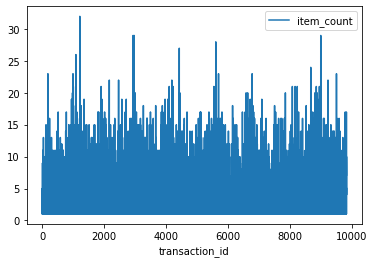

In [10]:
df = pd.DataFrame({'transaction_id': list(transactions.keys()), 
                   'item_count': [len(each) for each in transactions.values()]})
df.plot(x='transaction_id', y='item_count')

In [11]:
df.loc[df['item_count'].idxmax()]

transaction_id    1216
item_count          32
Name: 1216, dtype: int64

(       transaction_id   item_count
 count     9835.000000  9835.000000
 mean      4917.000000     4.409456
 std       2839.264283     3.589385
 min          0.000000     1.000000
 25%       2458.500000     2.000000
 50%       4917.000000     3.000000
 75%       7375.500000     6.000000
 max       9834.000000    32.000000,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f5f5f8ecd90>)

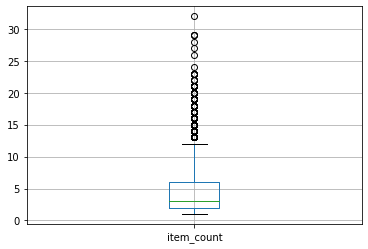

In [13]:
df.describe(), df.boxplot(column=["item_count"])

In [20]:
algo_obj = Arules()
algo_obj.level_process(transactions, 1, 0)
level_one_result = algo_obj.frequents[0]
item_list = list()
for each in level_one_result:
  item_list.append({'item': list(each)[0], 'frequents': level_one_result[each]})
item_list

[{'frequents': 106, 'item': 'canned vegetables'},
 {'frequents': 365, 'item': 'dessert'},
 {'frequents': 545, 'item': 'butter'},
 {'frequents': 744, 'item': 'pip fruit'},
 {'frequents': 163, 'item': 'processed cheese'},
 {'frequents': 189, 'item': 'detergent'},
 {'frequents': 30, 'item': 'snack products'},
 {'frequents': 22, 'item': 'organic sausage'},
 {'frequents': 279, 'item': 'frozen meals'},
 {'frequents': 241, 'item': 'hard cheese'},
 {'frequents': 414, 'item': 'white bread'},
 {'frequents': 711, 'item': 'fruit/vegetable juice'},
 {'frequents': 785, 'item': 'newspapers'},
 {'frequents': 22, 'item': 'cocoa drinks'},
 {'frequents': 279, 'item': 'misc. beverages'},
 {'frequents': 32, 'item': 'syrup'},
 {'frequents': 80, 'item': 'turkey'},
 {'frequents': 329, 'item': 'UHT-milk'},
 {'frequents': 55, 'item': 'sparkling wine'},
 {'frequents': 106, 'item': 'salt'},
 {'frequents': 23, 'item': 'tidbits'},
 {'frequents': 60, 'item': 'female sanitary products'},
 {'frequents': 875, 'item': '

In [21]:
df_items = pd.DataFrame(item_list)

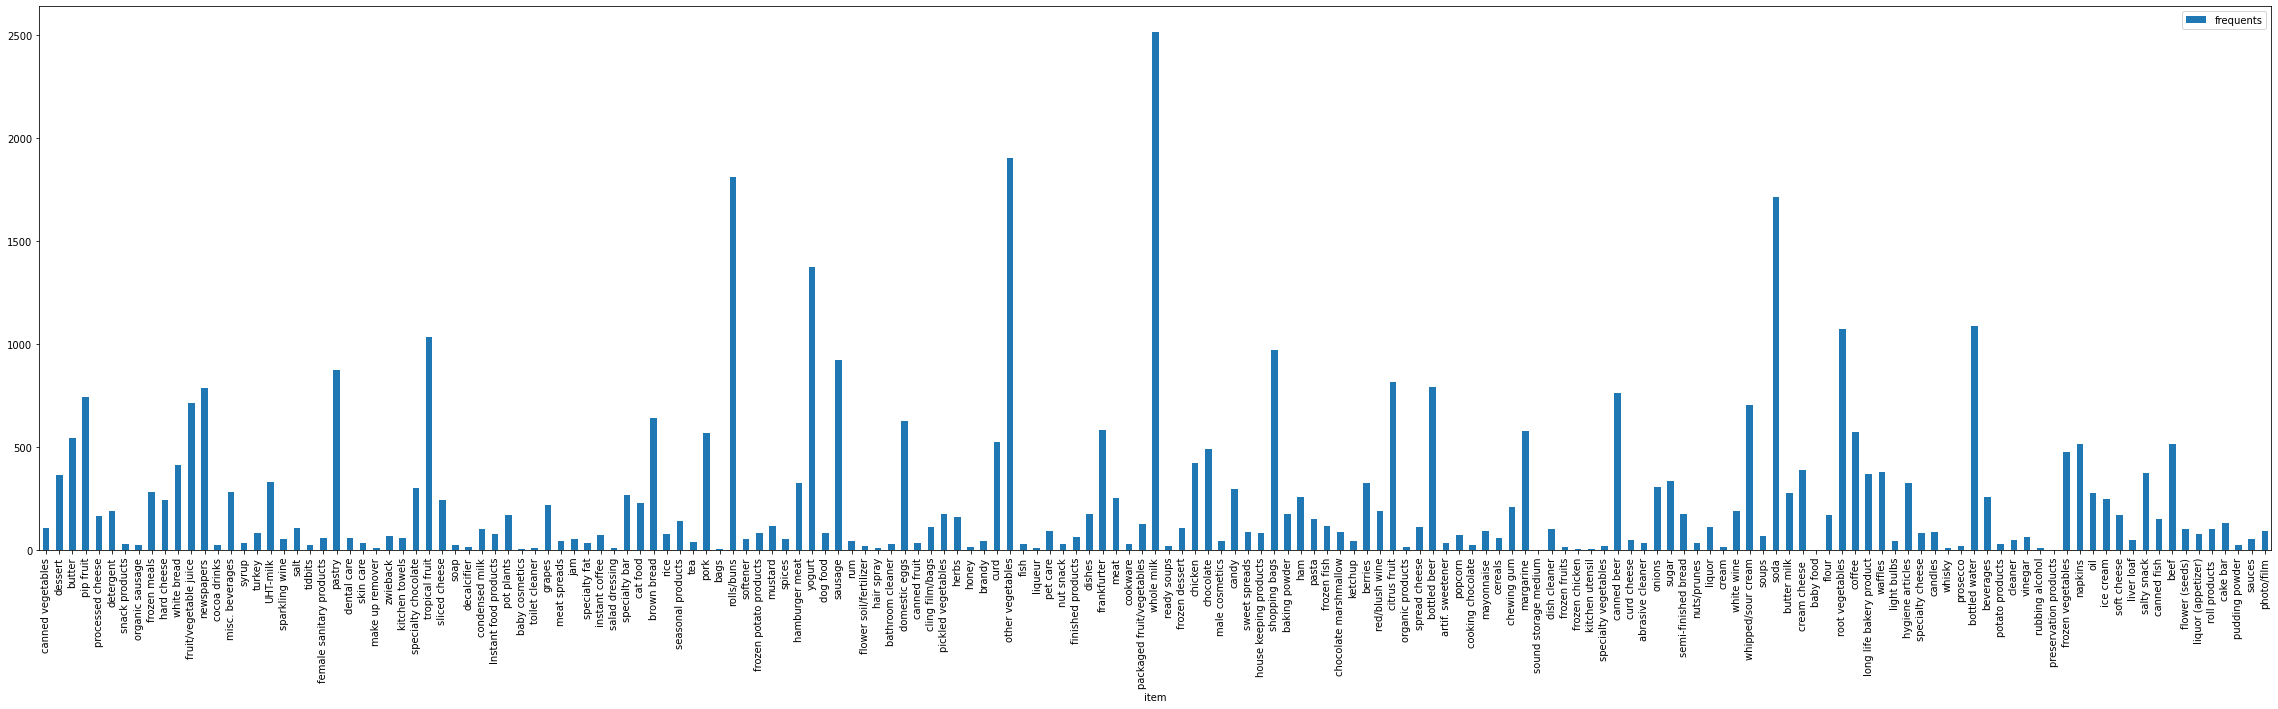

In [22]:
df_items.plot.bar(figsize=(40,10), x='item', y='frequents')

In [23]:
df_items.sort_values(by=['frequents'], inplace=True)
df_items.tail(10)

,item,frequents
60,sausage,924
93,shopping bags,969
29,tropical fruit,1032
136,root vegetables,1072
146,bottled water,1087
58,yogurt,1372
131,soda,1715
52,rolls/buns,1809
73,other vegetables,1903
84,whole milk,2513


In [24]:
df_items.head(10)

,item,frequents
113,sound storage medium,1
134,baby food,1
152,preservation products,2
51,bags,4
117,kitchen utensil,4
36,baby cosmetics,6
116,frozen chicken,6
37,toilet cleaner,7
144,whisky,8
25,make up remover,8


(         frequents
 count   169.000000
 mean    256.609467
 std     379.006378
 min       1.000000
 25%      38.000000
 50%     103.000000
 75%     305.000000
 max    2513.000000, <matplotlib.axes._subplots.AxesSubplot at 0x7f5f5ef87bd0>)

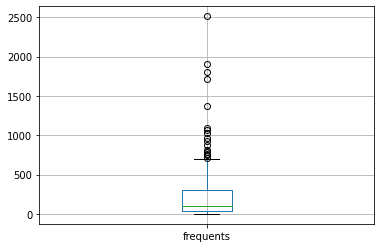

In [25]:
df_items.describe(), df_items.boxplot(column=["frequents"])

In [26]:
transactionss = convert_csv_to_dict_data(groceries_file_path)
algo = Arules()
frequents = algo.get_frequent_item_sets(transactionss, 0.005)
for each in frequents[:10]:
  print(each)

frozenset({'whole milk', 'tropical fruit', 'other vegetables', 'yogurt'})
frozenset({'whole milk', 'fruit/vegetable juice', 'other vegetables', 'yogurt'})
frozenset({'whole milk', 'root vegetables', 'other vegetables', 'yogurt'})
frozenset({'citrus fruit', 'root vegetables', 'other vegetables', 'whole milk'})
frozenset({'whole milk', 'root vegetables', 'tropical fruit', 'other vegetables'})
frozenset({'whole milk', 'root vegetables', 'tropical fruit', 'yogurt'})
frozenset({'whole milk', 'rolls/buns', 'other vegetables', 'yogurt'})
frozenset({'root vegetables', 'whole milk', 'rolls/buns', 'other vegetables'})
frozenset({'whipped/sour cream', 'root vegetables', 'other vegetables', 'whole milk'})
frozenset({'pip fruit', 'whole milk', 'root vegetables', 'other vegetables'})


In [27]:
l = algo.get_arules(min_sup=0.005, min_conf=0.2)
for each in l:
  print(str(each))

['root vegetables', 'yogurt']->['whole milk', 'tropical fruit'] support: 0.0056939501779359435, lift: 5.212371290127195, confidence: 0.2204724409448819
['root vegetables', 'tropical fruit']->['whole milk', 'yogurt'] support: 0.0056939501779359435, lift: 4.828813663343766, confidence: 0.27053140096618356
['pip fruit', 'root vegetables']->['whole milk', 'other vegetables'] support: 0.005490594814438231, lift: 4.716272378516624, confidence: 0.35294117647058826
['root vegetables', 'tropical fruit']->['whole milk', 'other vegetables'] support: 0.007015760040671073, lift: 4.4542572463768115, confidence: 0.3333333333333333
['citrus fruit', 'root vegetables']->['whole milk', 'other vegetables'] support: 0.005795627859684799, lift: 4.377459707646177, confidence: 0.3275862068965517
['fruit/vegetable juice', 'other vegetables']->['whole milk', 'yogurt'] support: 0.005083884087442806, lift: 4.3114407708426485, confidence: 0.24154589371980675
['pip fruit', 'other vegetables']->['whole milk', 'root 

In [28]:
transactionss = convert_csv_to_dict_data(groceries_file_path)
algo = Arules()
frequents = algo.get_frequent_item_sets(transactionss, 0.01)
for each in frequents[:10]:
  print(each)

frozenset({'whole milk', 'whipped/sour cream', 'other vegetables'})
frozenset({'citrus fruit', 'whole milk', 'yogurt'})
frozenset({'domestic eggs', 'whole milk', 'other vegetables'})
frozenset({'rolls/buns', 'other vegetables', 'yogurt'})
frozenset({'whole milk', 'fruit/vegetable juice', 'other vegetables'})
frozenset({'whole milk', 'tropical fruit', 'yogurt'})
frozenset({'whole milk', 'sausage', 'other vegetables'})
frozenset({'whole milk', 'other vegetables', 'yogurt'})
frozenset({'pip fruit', 'whole milk', 'other vegetables'})
frozenset({'whole milk', 'other vegetables', 'pastry'})


In [31]:
l = algo.get_arules(min_sup=0.01, min_conf=0.4)
for each in l:
  print(str(each))

['citrus fruit', 'root vegetables']->['other vegetables'] support: 0.010371123538383325, lift: 3.0296084222733612, confidence: 0.5862068965517241
['root vegetables', 'tropical fruit']->['other vegetables'] support: 0.012302999491611592, lift: 3.020999134344196, confidence: 0.5845410628019324
['root vegetables', 'rolls/buns']->['other vegetables'] support: 0.012201321809862735, lift: 2.5948898128258175, confidence: 0.502092050209205
['root vegetables', 'yogurt']->['other vegetables'] support: 0.012913065582104729, lift: 2.5840777719390435, confidence: 0.5
['whipped/sour cream', 'yogurt']->['other vegetables'] support: 0.010167768174885612, lift: 2.5334095803323957, confidence: 0.49019607843137253
['whole milk', 'root vegetables']->['other vegetables'] support: 0.023182511438739197, lift: 2.4497701954349353, confidence: 0.47401247401247404
['whole milk', 'pork']->['other vegetables'] support: 0.010167768174885612, lift: 2.370713552237655, confidence: 0.45871559633027525
['whole milk', 'w